# LSTM RNN Model for Patent Technology Classification

In [42]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda
from tensorflow.keras.layers import Dropout, Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.initializers import glorot_uniform
from keras.preprocessing import image
from keras.utils import layer_utils, to_categorical
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
#Conv2D output: 4+D tensor with shape: batch_shape + (new_rows, new_cols, filters) 
#if data_format='channels_last'. 
from gensim.models import KeyedVectors
import tensorflow as tf
from gensim import utils
from itertools import compress 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import csv
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pip install gensim

     |████████████████████████████████| 24.2 MB 79 kB/s s eta 0:00:01
     |████████████████████████████████| 119 kB 50.1 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-4.2.0-py3-none-any.whl size=109630 sha256=5dbdcad7c49c8deebfd204dc59608c7853438f177ec7e017a761323537bc2ada
  Stored in directory: /root/.cache/pip/wheels/25/88/e3/7cd51a6379cac37213cac47545a27688782752ff66351b953d
Successfully built smart-open
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Dataset description

* Traning examples will be 200 dimensional word vectors stacked vertically, representing the concatenation of title of abstract section of patents granted since 1970.

* Tech_classes data will be 3 digits CPC classfication of patents

* Citations_class will be a classification based on distribution of 5-year raw citation counts, within the given patent's CPC 3 digit technology class. Each patent has exactly one of the 4 following labels:
 1. Citation count greater or euqal to the 99% percentile (top1%)
 2. Citation count greater or equal to the 90% percentile ()
 3. Citation count less than 90% percentile but at least 1 ()
 4. Citation count is exactly 0 ()

## Patent RNN Model Architecture

In [4]:
#Import the dataframe
dataframe = pd.read_csv("/floyd/input/patent_prerank_upd/patent_prerank_upd.csv")

##How should I make input_size equal for all examples? Add padding?

In [9]:
def Patent_RNN_Model(input_shape = [100, 200], class_num = 125):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input matrix 
    class_num -- total number of classes 

    Returns:
    model -- a model instance in Keras
    """
    
    embeddings = Input(shape=input_shape) 
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units = 128, return_sequences= True)(embeddings)#Set the units and return_sequences parameters.
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X = LSTM(units = 128, return_sequences= True)(embeddings)#Set the units and return_sequences parameters.
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X = LSTM(units = 128, return_sequences= True)(embeddings)#Set the units and return_sequences parameters.
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units = 128, return_sequences= False)(X)
    
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(units = class_num)(X)
    # Add a softmax activation
    X = Activation("softmax")(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = embeddings, outputs = X)
    
    ### END CODE HERE ###
    
    return model

# Training

In [6]:
word_vectors_sg = KeyedVectors.load('word2vec_sg.wordvectors')

def matrix_generator(dataframe, list_IDs_temp, min_len = 1, max_len = 100, dim = (100, 200)):
    '''
    Input:
    filename: name of the csv file we want to read data from
    list_TDs_temp: indeces for minibatch
    min_len: minimum number of tokenized words for a title + abstraction text
    max_len: maximum number of tokenized words for a title + abstraction text
    dim: dimension of outputing matrix representation of text
    
    Output:
    X: batch of matrix representations of num_doc number of title+abstraction texts
    y: labels
    '''
    batch_size = len(list_IDs_temp)
    X = np.zeros((batch_size, *dim))
    y = np.zeros((1, batch_size), dtype = int)
    counter = 0
    
    for idx in list_IDs_temp:
        if dataframe.iloc[idx]["abstract"] == 'NULL':
            line = re.sub('[^a-zA-Z0-9]', ' ', str(dataframe.iloc[idx]["title"])) # remove non-letters and non-numbers
            bool_list = [word in word_vectors_sg for word in utils.simple_preprocess(line)]
            filtered_line = list(compress(utils.simple_preprocess(line), bool_list)) #some infrequency words are not included in the vocab, 
            #we remove then
            length = len(filtered_line)
            if length >= min_len:
                matrix = word_vectors_sg[filtered_line] # generate document matrix representation from tokens
                X_row = np.pad(matrix, ((0, max_len - length),(0, 0))).reshape([*dim])
                X[counter] = X_row
                y[0, counter] = dataframe.iloc[idx]["label"] - 1
        else:
            line = re.sub('[^a-zA-Z0-9]', ' ', str(dataframe.iloc[idx]["title"]) + ' ' + str(dataframe.iloc[idx]["abstract"])) # remove non-letters and non-numbers
            bool_list = [word in word_vectors_sg for word in utils.simple_preprocess(line)]
            filtered_line = list(compress(utils.simple_preprocess(line), bool_list)) #some infrequent words are not included in the vocab, 
            #we remove then
            length = len(filtered_line)
            if length >= min_len and length <= max_len:
                matrix = word_vectors_sg[filtered_line] # generate document matrix representation from tokens
                X_row = np.pad(matrix, ((0, max_len - length),(0, 0))).reshape([*dim])
                X[counter] = X_row
                y[0, counter] = dataframe.iloc[idx]["label"] - 1
            elif length > max_len:
                matrix = word_vectors_sg[filtered_line[0:max_len]] # generate document matrix representation from tokens
                X_row = matrix.reshape([*dim])
                X[counter] = X_row
                y[0, counter] = dataframe.iloc[idx]["label"] - 1
        counter += 1
    return X, np.squeeze(y)

In [24]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, dataframe, batch_size=100, text_length = 100,
                 n_classes=125, shuffle=False):
        'Initialization'
        self.dataframe = dataframe
        self.dim = (text_length, 200)
        self.batch_size = batch_size
        self.list_IDs = list(range(len(dataframe.loc[:, "patent_id"])))
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataframe.loc[:, "patent_id"]) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X, y = matrix_generator(self.dataframe, list_IDs_temp)
        return X, to_categorical(y, num_classes=self.n_classes)

In [29]:
class DataGenerator2(Sequence):
    'Generates data for Keras'
    def __init__(self, dataframe, batch_size=100, text_length = 100,
                 n_classes=125, shuffle=False):
        'Initialization'
        self.dataframe = dataframe
        self.dim = (text_length, 200)
        self.batch_size = batch_size
        self.list_IDs = list(range(len(dataframe.loc[:, "patent_id"])))
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.n = 0
        self.max = self.__len__()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataframe.loc[:, "patent_id"]) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        y = self.__data_generation(list_IDs_temp)

        return y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        _, y = matrix_generator(self.dataframe, list_IDs_temp)
        return to_categorical(y, num_classes=self.n_classes)
    
    def __next__(self):
        if self.n >= self.max:
           self.n = 0
        y = self.__getitem__(self.n)
        self.n += 1
        return y

In [64]:
grouped = dataframe.groupby('label')
small = grouped.apply(lambda x: x.sample(frac=0.15, random_state = 1))
train = small.apply(lambda x: x.sample(frac=0.98, random_state = 1))
test = pd.concat([small,train]).drop_duplicates(keep=False)

# Generators
training_generator = DataGenerator(train)
validation_generator = DataGenerator(test)

In [65]:
train.shape

(996609, 7)

In [66]:
test.shape

(20339, 7)

In [10]:
patentmodel = Patent_RNN_Model()
patentmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 200)]        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          168448    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 125)               16125     
_________________________________________________________________
activation (Activation)      (None, 125)               0     

In [11]:
patentmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
patentmodel.fit(training_generator, validation_data = validation_generator, epochs = 5)

Epoch 1/5
9966/9966 [==============================] - 2128s 214ms/step - loss: 1.9105 - accuracy: 0.5157 - val_loss: 1.2710 - val_accuracy: 0.6577
Epoch 2/5
9966/9966 [==============================] - 2115s 212ms/step - loss: 1.2568 - accuracy: 0.6655 - val_loss: 1.1034 - val_accuracy: 0.6942
Epoch 3/5
9966/9966 [==============================] - 2108s 212ms/step - loss: 1.1520 - accuracy: 0.6891 - val_loss: 1.0498 - val_accuracy: 0.7061
Epoch 4/5
9966/9966 [==============================] - 2093s 210ms/step - loss: 1.1004 - accuracy: 0.7008 - val_loss: 1.0182 - val_accuracy: 0.7163
Epoch 5/5
9966/9966 [==============================] - 2100s 211ms/step - loss: 1.0663 - accuracy: 0.7085 - val_loss: 1.0112 - val_accuracy: 0.7140


In [44]:
patentmodel.save('RNN_v1_techclass')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cnn_v2_citation/assets


In [12]:
patentmodel = load_model('RNN_v1_techclass')

# Model evaluation using the smaller test set

In [13]:
patentmodel.evaluate(validation_generator)

203/203 [==============================] - 41s 201ms/step - loss: 1.0121 - accuracy: 0.7137


[1.0121026039123535, 0.7136945724487305]

# Model evaluation using all of the example left unused

In [21]:
test_large = pd.concat([dataframe,small]).drop_duplicates(keep=False)

In [28]:
print(test_large.shape)

(5762712, 7)


In [25]:
validation_generator_large = DataGenerator(test_large)

In [30]:
validation_generator2_large = DataGenerator2(test_large)

In [17]:
patentmodel.evaluate(validation_generator_large)

57627/57627 [==============================] - 10815s 188ms/step - loss: 1.0090 - accuracy: 0.7138


[1.0090017318725586, 0.7137869596481323]

In [26]:
prediction = patentmodel.predict(validation_generator_large)

In [27]:
classes_predictions = np.argmax(prediction, axis = 1)

In [32]:
labels = []
for i in range(5762712 // 100):
    y = next(validation_generator2_large)
    labels.append(y) 

In [36]:
ground_true = np.vstack(labels)

In [37]:
ground_true_int = np.argmax(ground_true, axis=1)

In [38]:
len(ground_true_int)

5762700

In [39]:
bool_list = []
for i in range(len(ground_true_int)):
    if ground_true_int[i] == classes_predictions[i]:
        bool_list.append(True)
    else:
        bool_list.append(False)

In [40]:
sum(bool_list) / len(ground_true_int)

0.7137876342686588

In [43]:
cnf_matrix_row = confusion_matrix(ground_true_int, classes_predictions, normalize = 'true')
cnf_matrix_col = confusion_matrix(ground_true_int, classes_predictions, normalize = 'pred')

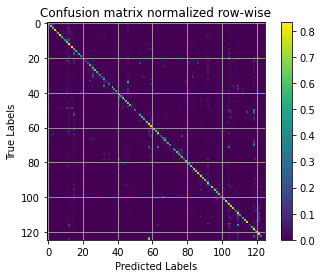

In [67]:

ticks=np.linspace(0, 124,num=125)
plt.imshow(cnf_matrix_row, interpolation='none')
plt.colorbar()
plt.title('Confusion matrix normalized row-wise')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.grid(True)

plt.savefig('conf_matrix_row.png')
plt.show()  

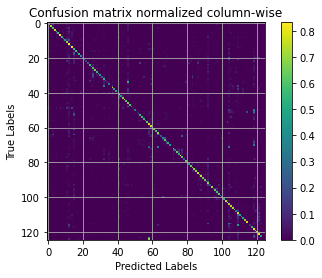

In [68]:
ticks=np.linspace(0, 124,num=125)
plt.imshow(cnf_matrix_row, interpolation='none')
plt.colorbar()
plt.title('Confusion matrix normalized column-wise')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.grid(True)

plt.savefig('conf_matrix_column.png')
plt.show()  

In [48]:
print(classification_report(ground_true_int, classes_predictions))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.81      0.73      0.77     81474
           1       0.56      0.56      0.56      4023
           2       0.58      0.73      0.65      4369
           3       0.66      0.60      0.63     20884
           4       0.78      0.77      0.78      6259
           5       0.57      0.61      0.59     10284
           6       0.81      0.57      0.67      3671
           7       0.82      0.83      0.82      9283
           8       0.70      0.54      0.61      6726
           9       0.62      0.50      0.56     16397
          10       0.69      0.48      0.57      4134
          11       0.63      0.68      0.65     72757
          12       0.82      0.83      0.83    411278
          13       0.58      0.42      0.49      7839
          14       0.79      0.82      0.80     71811
          15       0.52      0.57      0.54     87163
          16       0.70      0.57      0.63      5044
          17       0.58    

In [18]:
subsection_id = { "A01" : 1,
                  "A21" : 2,
                  "A22" : 3,
                  "A23" : 4,
                  "A24" : 5,
                  "A41" : 6,
                  "A42" : 7,
                  "A43" : 8,
                  "A44" : 9,
                  "A45" : 10,
                  "A46" : 11,
                  "A47" : 12, 
      
                  "A61" : 13,
                  "A62" : 14,
                  "A63" : 15,
      
                  "B01" : 16,
                  "B02" : 17,
                  "B03" : 18,
                  "B04" : 19,
                  "B05" : 20,
                  "B06" : 21,
                  "B07" : 22,
                  "B08" : 23,
                  "B09" : 24,
                  "B21" : 25,
                  "B22" : 26,
                  "B23" : 27,
                  "B24" : 28,
                  "B25" : 29,
                  "B26" : 30,
                  "B27" : 31,
                  "B28" : 32,
                  "B29" : 33,
                  "B30" : 34,
                  "B31" : 35,
                  "B32" : 36,
                  "B33" : 37,
                  "B41" : 38,
                  "B42" : 39,
                  "B43" : 40,
                  "B44" : 41,
                  "B60" : 42,
                  "B61" : 43,
                  "B62" : 44,
                  "B63" : 45,
                  "B64" : 46, 
                  "B65" : 47,
                  "B66" : 48,
                  "B67" : 49,
                  "B68" : 50,
                  "B81" : 51,
                  "B82" : 52, 
      
                  "C01" : 53,
                  "C02" : 54,
                  "C03" : 55,
                  "C04" : 56,
                  "C05" : 57,
                  "C06" : 58,
                  "C07" : 59,
                  "C08" : 60,
                  "C09" : 61,
                  "C10" : 62,
                  "C11" : 63,
                  "C12" : 64,
                  "C13" : 65,
                  "C14" : 66,
      
                  "C21" : 67,
                  "C22" : 68,
                  "C23" : 69,
      
                  "C25" : 70,
                  "C30" : 71,
                  "C40" : 72,
      
                  "D01" : 73,
                  "D02" : 74,
                  "D03" : 75,
                  "D04" : 76,
                  "D05" : 77,
                  "D06" : 78,
                  "D07" : 79,
                  "D21" : 80,
      
                  "E01" : 81,
                  "E02" : 82,
                  "E03" : 83,
                  "E04" : 84,
                  "E05" : 85,
                  "E06" : 86,
                  "E21" : 87,
      
                  "F01" : 88,
                  "F02" : 89,
                  "F03" : 90,
                  "F04" : 91,
    
                  "F15" : 92,
                  "F16" : 93,
                  "F17" : 94,
                  "F21" : 95,
                  "F22" : 96,
                  "F23" : 97,
                  "F24" : 98,
                  "F25" : 99,
                  "F26" : 100,
                  "F27" : 101,
                  "F28" : 102,
      
                  "F41" : 103,
                  "F42" : 104,
      
                  "G01" : 105,
                  "G02" : 106,
                  "G03" : 107,
                  "G04" : 108,
                  "G05" : 109,
                  "G06" : 110,
                  "G07" : 111,
                  "G08" : 112,
                  "G09" : 113,
                  "G10" : 114,
                  "G11" : 115,
                  "G12" : 116,
                  "G16" : 117,
                  "G21" : 118,
      
                  "H01" : 119,
                  "H02" : 120,
                  "H03" : 121,
                  "H04" : 122,
                  "H05" : 123,
      
                  "Y02" : 124,
                  "Y10" : 125 }